Implementation of a statistical arbitrage methodology outlined in Avellaneda (2008) "Statistical Arbitrage in the U.S. Equities Market".

We regress a given stock returns on a relevant ETF's returns and try to model the residuals as a mean-reverting O-U process. This serves as the basis for a signal on which we build a backtest.

In [1]:
import pandas as pd
import numpy as np
import bs4 as bs
import requests
import yfinance as yf
import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from regressors import stats
import bt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test = yf.download(['MSFT'])

[*********************100%***********************]  1 of 1 completed


In [3]:
test = test.reset_index()

In [4]:
test['Ticker'] = 'MSFT'

In [5]:
test['Date'].iloc[0]

Timestamp('1986-03-13 00:00:00')

In [6]:
test['ts'] = pd.Timestamp(test['Date'].iloc[0]) + pd.Timedelta('16H')

In [7]:
test.rename(columns={'Date':'asof_date','Open':'open','Close':'close','High':'high','Low':'low','Volume':'volume',
                     'Ticker':'ticker','Adj Close':'adj_close'})

,asof_date,open,high,low,close,adj_close,volume,ticker,ts
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1031788800,MSFT,1986-03-13 16:00:00
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000,MSFT,1986-03-13 16:00:00
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200,MSFT,1986-03-13 16:00:00
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400,MSFT,1986-03-13 16:00:00
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400,MSFT,1986-03-13 16:00:00
...,...,...,...,...,...,...,...,...,...
9348,2023-04-17,289.929993,291.600006,286.160004,288.799988,288.799988,23836200,MSFT,1986-03-13 16:00:00
9349,2023-04-18,291.570007,291.760010,287.010010,288.369995,288.369995,20161800,MSFT,1986-03-13 16:00:00
9350,2023-04-19,285.989990,289.049988,284.540009,288.450012,288.450012,17150300,MSFT,1986-03-13 16:00:00
9351,2023-04-20,285.250000,289.029999,285.079987,286.109985,286.109985,23244400,MSFT,1986-03-13 16:00:00


### Get all recent tickers of S&P500

In [8]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]

In [9]:
len(tickers)

503

In [10]:
data = yf.download(["SPY"]+tickers, period = "5y")

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


### Compute returns

In [11]:
rets = data['Adj Close'].pct_change()
rets.dropna(inplace=True,axis=0, how='all')
rets.dropna(inplace=True,axis=1, how='any')

rets_SPX = pd.DataFrame(rets['SPY'])
rets.drop(['SPY'], axis=1, inplace=True)

In [12]:
mu = rets.mean()
sig = rets.std()

z_rets = (rets - mu)/sig

<AxesSubplot:xlabel='Date'>

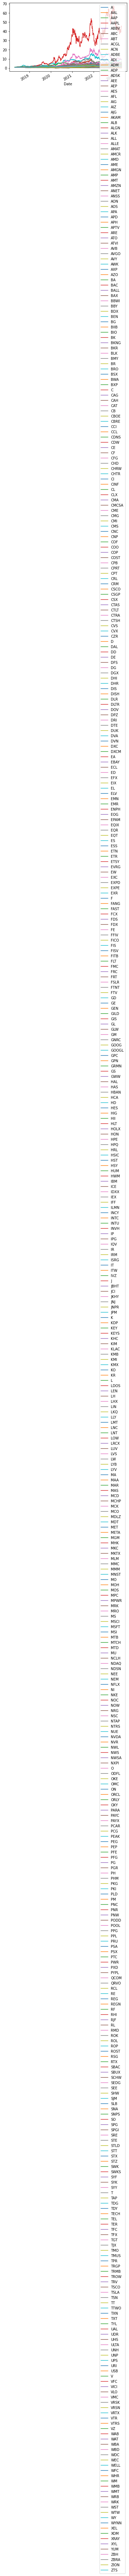

In [13]:
(1+rets).cumprod().plot()

In [14]:
plt.show()

<AxesSubplot:ylabel='Frequency'>

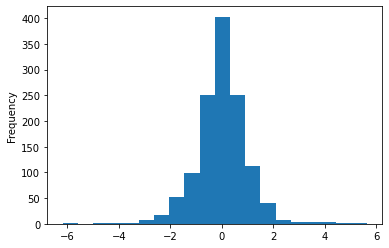

In [15]:
z_rets['AAPL'].plot.hist(bins=20)

In [16]:
pca = PCA(n_components=5).fit(rets)

In [17]:
pcs = ['PC' + str(i) for i in range(1,51)]
explained_variance_ratio = pd.DataFrame(zip(pcs, pca.explained_variance_ratio_), columns=['PC', 'RatioVarianceExplained'])


<AxesSubplot:xlabel='PC', ylabel='RatioVarianceExplained'>

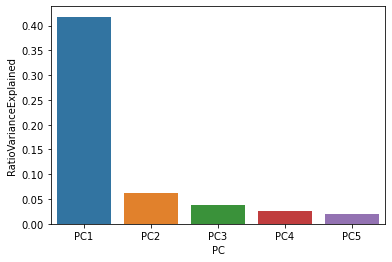

In [18]:
sns.barplot(data=explained_variance_ratio, x='PC', y='RatioVarianceExplained')

### Eigenportfolio returns

<AxesSubplot:xlabel='Date'>

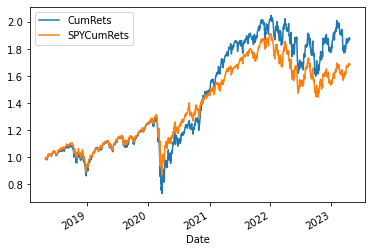

In [19]:
w=abs(pca.components_[0])/sum(abs(pca.components_[0]))
eigenptf = pd.DataFrame(rets.dot(w.T), columns=['Returns'])
eigenptf['CumRets'] = (1+eigenptf['Returns']).cumprod()
eigenptf = eigenptf.join(rets_SPX, how='left')
eigenptf['SPYCumRets'] = (1+eigenptf['SPY']).cumprod()
eigenptf[['CumRets','SPYCumRets']].plot()

<AxesSubplot:xlabel='Tickers'>

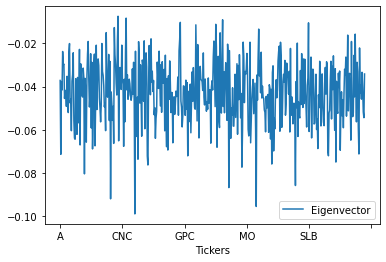

In [20]:
pd.DataFrame(zip(rets.columns, pca.components_[0]), columns=['Tickers', 'Eigenvector']).plot(x='Tickers')

### Getting sectors ETF data

In [21]:
etf_tickers = ['QQQ','IYR','IYT','OIH','KBE','RTH','SMH','XLE','XLF','XLI','XLK','XLP','XLV']
etf_data = yf.download(etf_tickers, period = "5y")

[*********************100%***********************]  13 of 13 completed


In [22]:
etf_data['Adj Close'].dropna()

,IYR,IYT,KBE,OIH,QQQ,RTH,SMH,XLE,XLF,XLI,XLK,XLP,XLV
Date,,,,,,,,,,,,,
2018-04-23,64.169640,179.979111,42.519604,501.699036,156.419937,89.723495,92.230774,57.415947,25.097010,69.008354,62.349861,44.102707,75.616608
2018-04-24,64.325768,176.323212,42.730320,497.801331,153.105850,88.939896,91.758720,56.800922,24.934795,67.080017,61.262974,43.822865,75.047745
2018-04-25,64.186996,178.160629,42.633739,502.070251,153.289413,89.446365,91.296097,57.252460,24.916773,67.271942,61.272430,43.901569,75.387222
2018-04-26,64.967636,176.784927,42.493267,508.195343,156.516556,91.711205,93.212662,58.085476,24.925787,67.025192,62.387672,44.163921,76.341476
2018-04-27,65.808990,179.036865,42.782997,505.225616,156.613190,93.029968,92.608421,57.470451,24.961832,66.888115,62.274246,44.400047,76.653458
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,84.860001,226.869995,37.320000,286.679993,318.839996,163.369995,251.899994,86.199997,33.259998,100.620003,149.190002,75.660004,134.460007
2023-04-18,84.699997,227.050003,36.820000,286.769989,318.859985,163.970001,253.029999,86.540001,33.360001,101.099998,149.649994,75.889999,133.539993
2023-04-19,85.120003,229.580002,37.950001,287.209991,318.709991,163.970001,250.630005,86.239998,33.439999,101.019997,149.220001,75.839996,133.949997


In [23]:
rets_etf = etf_data['Adj Close'].pct_change()
rets_etf = rets_etf.dropna()

In [24]:
rets_etf.shape

(1258, 13)

In [25]:
rets.shape

(1258, 490)

In [26]:
df = rets[['JPM']].join(rets_etf, how='left')

<AxesSubplot:>

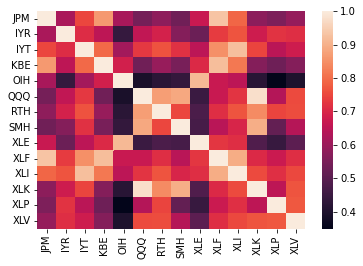

In [27]:
corrMat = df.corr()
sns.heatmap(corrMat)

## JPM vs Financials ETF

### OLS vs Ridge Regression

In [28]:
model = sm.OLS(rets['JPM'],rets_etf['XLF'])
res = model.fit()
print(res.summary())

beta_etf = res.params[0]

                                 OLS Regression Results                                
Dep. Variable:                    JPM   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              8356.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                        0.00
Time:                        12:16:18   Log-Likelihood:                          4397.6
No. Observations:                1258   AIC:                                     -8793.
Df Residuals:                    1257   BIC:                                     -8788.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
model = Ridge(alpha=0.01).fit(rets_etf[etf_tickers],rets['JPM'].values)

In [30]:
summary = stats.summary(model,rets_etf[etf_tickers],rets['JPM'].values)

Residuals:
    Min      1Q  Median      3Q     Max
-0.0636 -0.0033  0.0001  0.0037  0.0514


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept  0.000205    0.000196   1.0455  0.295986
x1         -0.036117    0.059935  -0.6026  0.546876
x2         -0.051879    0.021523  -2.4105  0.016075
x3         -0.007626    0.030751  -0.2480  0.804185
x4         -0.027107    0.012434  -2.1801  0.029435
x5          0.097453    0.022066   4.4164  0.000011
x6         -0.075830    0.034702  -2.1852  0.029058
x7          0.001031    0.018856   0.0547  0.956417
x8          0.038828    0.021385   1.8156  0.069664
x9          1.117087    0.040291  27.7256  0.000000
x10         0.000510    0.042677   0.0120  0.990466
x11        -0.013462    0.053364  -0.2523  0.800881
x12        -0.032934    0.032354  -1.0179  0.308898
x13        -0.035484    0.030977  -1.1455  0.252220
---
R-squared:  0.88265,    Adjusted R-squared:  0.88143
F-statistic: 719.76 on 13 features


<AxesSubplot:xlabel='Date'>

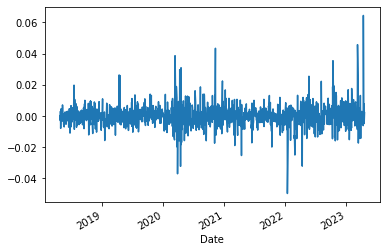

In [31]:
res.resid.plot()

### Modelling errors as an OU process

#### Using a 60-days window as in Avallaneda et al. 2019

<AxesSubplot:xlabel='Date'>

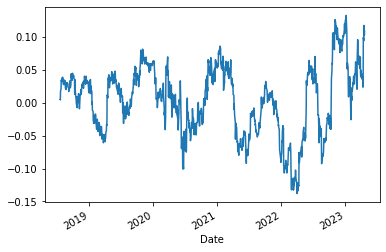

In [32]:
X_process= res.resid.rolling(60).sum()
X_process.plot()

#### Estimate AR(1) parameters

$dX_t = \kappa(m-X_{t-1})dt + \sigma dW_t$

Then we can write:

$X_t = a + bX_{t-1} + \epsilon_t$

with:

$a = (1 - e^{-\kappa \Delta t})m$

$b =  e^{-\kappa \Delta t}$

$V(\epsilon) = \sigma^2 \frac{1-e^{-2 \kappa \Delta t}}{2 \kappa}$

In [33]:
res_df = pd.DataFrame(X_process, columns=['X'])
res_df['lagged_X'] = res_df['X'].shift()
res_df.dropna(inplace=True)

In [34]:
X = res_df['lagged_X']
X = sm.add_constant(X)
model = sm.OLS(res_df['X'],X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 2.770e+04
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:16:19   Log-Likelihood:                 3759.1
No. Observations:                1198   AIC:                            -7514.
Df Residuals:                    1196   BIC:                            -7504.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.490      0.6

In [35]:
kappa = -np.log(res.params[1]) * 252
m = res.params[0]/(1-res.params[1])
var_eps = np.var(res.resid)
sig_X = np.sqrt(var_eps*2*kappa/(1-res.params[1]**2))
sig_eq = np.sqrt(var_eps/(1-res.params[1]**2))

### Build S-score: measure of distance to equilibrium of the cointegrated residual in units standard deviations

In [36]:
res_df['s_score'] = (res_df['X'] - m)/sig_eq

<AxesSubplot:xlabel='Date'>

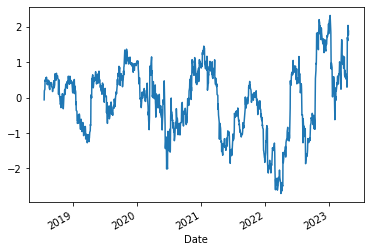

In [37]:
res_df['s_score'].plot()

In [38]:
tw = res_df[['s_score']].copy()

In [39]:
sbo, sso = 1.25,1.25
sbc = 0.75
ssc = 0.50

tw['stock_weights'] = tw['s_score']*0
tw['etf_weights'] = tw['s_score']*0

tw['stock_weights'].iloc[np.where(tw['s_score'] < - sbo)] = 1
tw['etf_weights'].iloc[np.where(tw['s_score'] < - sbo)] = - beta_etf
tw['stock_weights'].iloc[np.where(tw['s_score'] > sso)] = -1
tw['etf_weights'].iloc[np.where(tw['s_score'] > sso)] = + beta_etf

# tw['weights'].iloc[np.where(tw['s_score'] < sbc)] = 0
# tw['weights'].iloc[np.where(tw['s_score'] > - ssc)] = 0

In [40]:
res_df['s_score']

Date
2018-07-19   -0.065033
2018-07-20    0.187871
2018-07-23    0.235600
2018-07-24    0.455428
2018-07-25    0.496076
                ...   
2023-04-17    1.605725
2023-04-18    2.035175
2023-04-19    1.901667
2023-04-20    1.761824
2023-04-21    1.873989
Name: s_score, Length: 1198, dtype: float64

In [41]:
sbo, sso = 1.25,1.25
sbc = 0.75
ssc = 0.50

res_df['stock_weights'] = res_df['s_score'] * 0.0

for t in range(1, res_df['s_score'].shape[0]):
    if res_df['stock_weights'].iloc[t-1]==0.0:
        if res_df['s_score'].iloc[t] < -sbo:
            res_df['stock_weights'].iloc[t] = 1.0
        elif res_df['s_score'].iloc[t] > sso:
            res_df['stock_weights'].iloc[t] = -1.0
        else:
            res_df['stock_weights'].iloc[t] = 0.0
    else:
        if res_df['stock_weights'].iloc[t-1] < 0 and res_df['s_score'].iloc[t] < sbc:
            res_df['stock_weights'].iloc[t] = 0.0
        elif res_df['stock_weights'].iloc[t-1] > 0 and res_df['s_score'].iloc[t]> -ssc:
            res_df['stock_weights'].iloc[t] = 0.0
        else:
            res_df['stock_weights'].iloc[t] = res_df['stock_weights'].iloc[t-1]



In [42]:
res_df['etf_weights'] = - beta_etf * res_df['stock_weights']

In [43]:
res_df[['stock_weights','etf_weights', 's_score']].loc['2019-07-20':'2019-08-05']

,stock_weights,etf_weights,s_score
Date,,,
2019-07-22,0.0,-0.0,-0.413431
2019-07-23,0.0,-0.0,-0.240213
2019-07-24,0.0,-0.0,-0.435994
2019-07-25,0.0,-0.0,-0.427582
2019-07-26,0.0,-0.0,-0.601247
2019-07-29,0.0,-0.0,-0.518727
2019-07-30,0.0,-0.0,-0.429300
2019-07-31,0.0,-0.0,-0.236781
2019-08-01,0.0,-0.0,-0.295348


In [44]:
tw = res_df[['stock_weights','etf_weights']].rename(columns={'stock_weights':'JPM', 'etf_weights':'XLF'})

In [45]:
tw.describe()

,JPM,XLF
count,1198.000000,1198.000000
mean,0.085142,-0.095333
std,0.543293,0.608323
min,-1.000000,-1.119696
25%,0.000000,0.000000
50%,0.000000,-0.000000
75%,0.000000,-0.000000
max,1.000000,1.119696


In [46]:
price_data = pd.DataFrame(data['Adj Close']['JPM']).join(etf_data['Adj Close']['XLF'], how='left')

In [47]:
s = bt.Strategy('etf_vs_stock', [bt.algos.WeighTarget(tw),bt.algos.Rebalance()],)

# now we create the Backtest
t = bt.Backtest(s, price_data)

In [48]:
res = bt.run(t)

In [49]:
res.display()

Stat                 etf_vs_stock
-------------------  --------------
Start                2018-04-22
End                  2023-04-21
Risk-free rate       0.00%

Total Return         -0.21%
Daily Sharpe         0.02
Daily Sortino        0.03
CAGR                 -0.04%
Max Drawdown         -18.45%
Calmar Ratio         -0.00

MTD                  -0.15%
3m                   2.73%
6m                   1.48%
YTD                  3.37%
1Y                   12.34%
3Y (ann.)            -1.31%
5Y (ann.)            -0.04%
10Y (ann.)           -
Since Incep. (ann.)  -0.04%

Daily Sharpe         0.02
Daily Sortino        0.03
Daily Mean (ann.)    0.15%
Daily Vol (ann.)     6.14%
Daily Skew           -1.83
Daily Kurt           33.88
Best Day             2.63%
Worst Day            -4.98%

Monthly Sharpe       0.02
Monthly Sortino      0.04
Monthly Mean (ann.)  0.14%
Monthly Vol (ann.)   6.11%
Monthly Skew         0.30
Monthly Kurt         3.66
Best Month           6.21%
Worst Month          -5.50%

<AxesSubplot:title={'center':'Equity Progression'}>

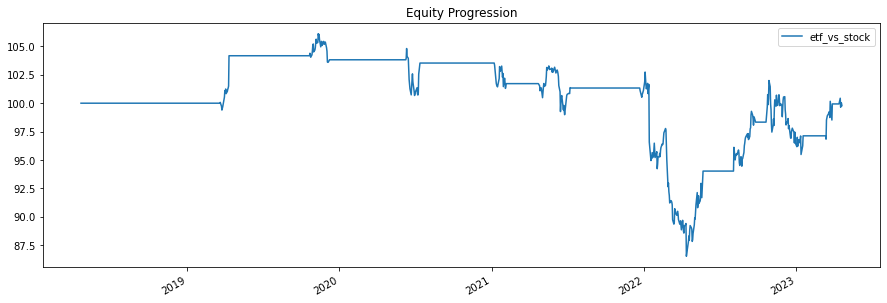

In [50]:
res.plot()

In [51]:
wdf = res.get_security_weights()
wdf.rename(columns={'JPM':'w_stock', 'XLF':'w_etf'},inplace=True)

## Scanning multiple stocks

In [53]:
sbux = yf.Ticker("SBUX")
tlry = yf.Ticker("TLRY")

print(sbux.info['sector'])
print(tlry.info['sector'])

KeyError: 'sector'

In [54]:
ticks = yf.Tickers(tickers)

In [56]:
sector = []
for tick in tickers:
    try:
        #         sector.append(yf.Ticker(tick).info['sector'])
    except:
        print('Error with ticker: ' + tick)

IndentationError: expected an indented block (<ipython-input-56-f2246ab07362>, line 5)

In [ ]:
np.unique(sector)

In [ ]:
yf.Ticker(ticks.symbols[0]).info['shortName']

In [ ]:
yf.Ticker(etf_tickers[0]).info

In [ ]:
for tick in etf_tickers:
    print(tick, " :", yf.Ticker(tick).info['shortName'])

In [ ]:
sector_etf_tick = {'IYR':'Real Estate', 'IYT':'Transportation', 'OIH':'Oil Services', 'KBE': 'Banks', 
                   'RTH':'Retail', 'XLE':'Energy', 'XLF':'Financials', 'XLI':'Industrials', 'XLK':'Technology', 
                   'XLP':'Consumer Cyclical', 'XLV':'Healthcare'}

In [ ]:
def get_beta(stock, etf, window=60):
    # make sure indices are aligned
    etf = etf.loc[stock.index]
    
    # run regression and return: beta, p-val, residuals
    model = sm.OLS(stock,etf)
    res = model.fit()
    
    return res.params[0], res.pvalue[0], res.resid

In [ ]:
def OH_params_estimation(resid, window=60):
    X = resid.rolling(window).sum()
    df = pd.DataFrame(X, columns=['X'])
    df['lagged_X'] = res_df['X'].shift()
    df.dropna(inplace=True)
    
    y = df['X']
    lagged_X = df['lagged_X']
    lagged_X = sm.add_constant(lagged_X)
    model = sm.OLS(y,lagged_X)
    res = model.fit()
    
    kappa = -np.log(res.params[1]) * 252
    m = res.params[0]/(1-res.params[1])
    var_eps = np.var(res.resid)
    sig_X = np.sqrt(var_eps*2*kappa/(1-res.params[1]**2))
    sig_eq = np.sqrt(var_eps/(1-res.params[1]**2))
    
    return kappa, m, var_eps, sig_X, sig_eq